In [ ]:
try:
  from future.utils import iteritems
except:
  !pip install future
  from future.utils import iteritems

In [ ]:
import numpy as np
import pandas as pd
import spacy
import os
import matplotlib.pyplot as plt
from spacy import displacy
from future.utils import iteritems
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import AdamW
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow.keras.backend as K

2024-04-16 00:57:42.364383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 00:57:42.364445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 00:57:42.366011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ner-data/ner.csv


In [ ]:
df = pd.read_csv("/kaggle/input/ner-data/ner.csv",
                 encoding = "ISO-8859-1",
                 on_bad_lines="skip")
df = df.ffill()

In [ ]:
df.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [ ]:
df = df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'shape'],axis=1)

In [ ]:
df

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O
...,...,...,...,...
1050790,PRP,47959.0,they,O
1050791,VBD,47959.0,responded,O
1050792,TO,47959.0,to,O
1050793,DT,47959.0,the,O


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   pos           1050795 non-null  object 
 1   sentence_idx  1050795 non-null  float64
 2   word          1050795 non-null  object 
 3   tag           1050795 non-null  object 
dtypes: float64(1), object(3)
memory usage: 32.1+ MB


In [ ]:
df.head()

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


In [ ]:
words = list(set(df['word'].values))
words.append("ENDPAD")
pos_tags = list(set(df['pos'].values))
tags = list(set(df['tag'].values))
words_encoded = {word: i for i, word in enumerate(words)}
pos_encoded = {pos_tag: i for i, pos_tag in enumerate(pos_tags)}
ner_tag_encoded = {tag: i for i, tag in enumerate(tags)}
get_encoded_tag = {tag: i for i, tag in iteritems(ner_tag_encoded)}

In [ ]:
def preprocess(df):
    def combine(group):
       return [(word, pos, tag) for word, pos, tag in zip(group['word'].values.tolist(),
                                                          group['pos'].values.tolist(),
                                                          group['tag'].values.tolist())]

    df=df.groupby(['sentence_idx']).apply(combine, include_groups = False).reset_index().rename(columns={0:'combined'})
    df['sentence']=df['combined'].apply(lambda sentence:" ".join([s[0] for s in sentence]))
    df['pos']=df['combined'].apply(lambda sentence:" ".join([s[1] for s in sentence]))
    df['tag']=df['combined'].apply(lambda sentence:" ".join([s[2] for s in sentence]))
    df['tag_list']=df['tag'].apply(lambda tag: tag.split())
    df.drop("combined", inplace=True, axis=1)
    return df

In [ ]:
df_preprocessed = preprocess(df)
df_preprocessed.head()

,sentence_idx,sentence,pos,tag,tag_list
0,1.0,Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,2.0,Families of soldiers killed in the conflict jo...,NNS IN NNS VBN IN DT NN VBD DT NNS WP VBD NNS ...,O O O O O O O O O O O O O O O O O O B-per O O ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,3.0,They marched from the Houses of Parliament to ...,PRP VBD IN DT NNS IN NN TO DT NN IN NNP NNP . ...,O O O O O O O O O O O B-geo I-geo O O O O O O ...,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,4.0,"Police put the number of marchers at 10,000 wh...",NNS VBD DT NN IN NNS IN CD IN NNS VBD PRP VBD ...,O O O O O O O O O O O O O O O O O O O O O O O ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,5.0,The protest comes on the eve of the annual con...,DT NN VBZ IN DT NN IN DT JJ NN IN NNP POS VBG ...,O O O O O O O O O O O B-geo O O B-org I-org O ...,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."


In [ ]:
sentences_list=df_preprocessed['sentence'].tolist()
tags_list=df_preprocessed['tag_list'].tolist()
for i, sentence in enumerate(sentences_list):
    sentences_list[i] = sentences_list[i].split()
print(sentences_list[0])
print('\n',tags_list[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']

 ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
encoded_tags=[[ner_tag_encoded[w] for w in tag] for tag in tags_list]
encoded_sentences=[[words_encoded[w] for w in sentence] for sentence in sentences_list]

In [ ]:
max_len = max(len(sentence) for sentence in encoded_sentences)
print(max_len)
padded_encoded_sentences=pad_sequences(maxlen=max_len,
                                       sequences=encoded_sentences,
                                       padding="post",
                                       value=len(words)-1)
padded_encoded_tags=pad_sequences(maxlen=max_len,
                                  sequences=encoded_tags,
                                  padding="post",
                                  value=ner_tag_encoded['O'])

140


In [ ]:
target = [to_categorical(i,num_classes = len(tags)) for i in padded_encoded_tags]
print("Shape of categorical labels for first input sequence: ",target[0].shape)
print("Vocabulary size: ",len(words))

Shape of categorical labels for first input sequence:  (140, 17)
Vocabulary size:  30172


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_encoded_sentences,
                                                    target,
                                                    test_size=0.2)

In [ ]:
embedding_dim=128

input = Input(shape=(max_len,))
model = Embedding(input_dim=len(words), output_dim=embedding_dim)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)
model = Model(input, out)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 140, 128)       │     3,862,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 140, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 140, 17)        │         4,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,129,553 (15.75 MB)

 Trainable params: 4,129,553 (15.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer=AdamW(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=[CategoricalAccuracy(), f1_score_metric, precision_metric, recall_metric])

history = model.fit(X_train, np.array(y_train),
                    batch_size=256,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - categorical_accuracy: 0.9129 - f1_score_metric: 0.8521 - loss: 0.4743 - precision_metric: 0.8736 - recall_metric: 0.8353 - val_categorical_accuracy: 0.9679 - val_f1_score_metric: 0.9727 - val_loss: 0.1192 - val_precision_metric: 0.9781 - val_recall_metric: 0.9674
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - categorical_accuracy: 0.9702 - f1_score_metric: 0.9756 - loss: 0.1057 - precision_metric: 0.9845 - recall_metric: 0.9668 - val_categorical_accuracy: 0.9799 - val_f1_score_metric: 0.9813 - val_loss: 0.0720 - val_precision_metric: 0.9940 - val_recall_metric: 0.9689
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - categorical_accuracy: 0.9827 - f1_score_metric: 0.9836 - loss: 0.0626 - precision_metric: 0.9948 - recall_metric: 0.9728 - val_categorical_accuracy: 0.9884 - val_f1_score_metric: 0.9883 - val_loss: 0.0441 - val_precision_metric: 0.9945 - val_recall_metric: 0.9822
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/s

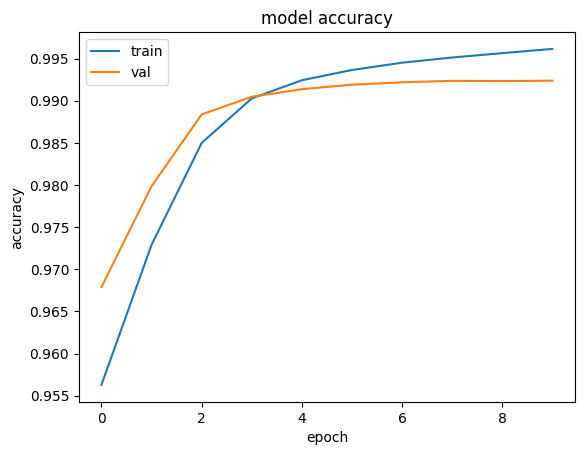

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

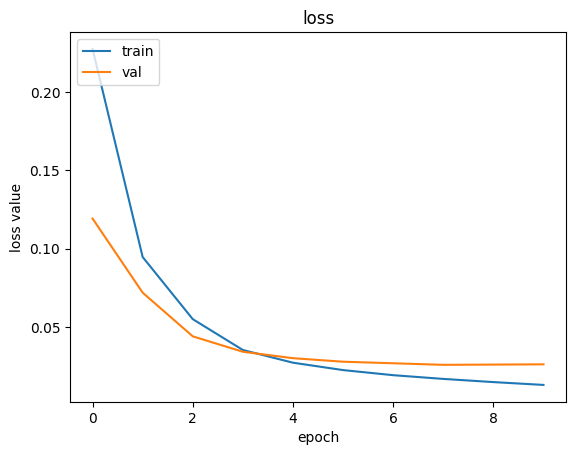

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

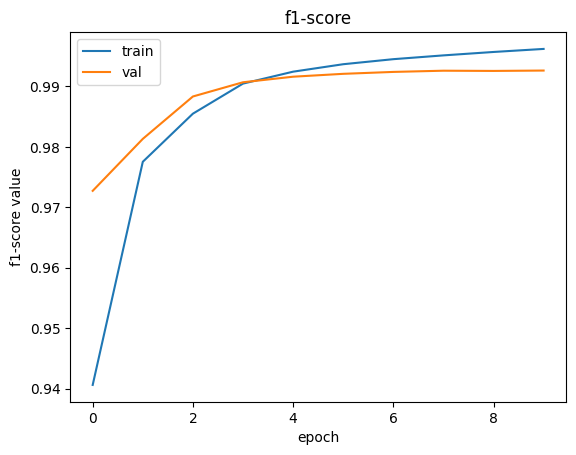

In [ ]:
plt.plot(history.history['f1_score_metric'])
plt.plot(history.history['val_f1_score_metric'])

plt.title('f1-score')
plt.ylabel('f1-score value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, np.asarray(y_test))

220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - categorical_accuracy: 0.9922 - f1_score_metric: 0.9924 - loss: 0.0268 - precision_metric: 0.9936 - recall_metric: 0.9912


[0.02633984573185444,
 0.9923288226127625,
 0.9925157427787781,
 0.9937335848808289,
 0.9913007020950317]

In [ ]:
preds=model.predict(X_test)

220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [ ]:
def convert_tags(test_data, preds, actual_preds):
    pred_tokens = []
    actual_tags = []
    pred_tags = []
    for i, data in enumerate(test_data):
        tokens = [words[x] if x != 0 else '<PAD>' for x in list(data)]
        actual_tags.extend([get_encoded_tag[x] for x in list(actual_preds[i])])
        pred_tags.extend([get_encoded_tag[x] for x in list(preds[i])])
        pred_tokens.extend(tokens)
    non_pad_indices = [i for i, token in enumerate(pred_tokens) if token != '<PAD>']
    actual_tags = [actual_tags[i] for i in non_pad_indices]
    pred_tags = [pred_tags[i] for i in non_pad_indices]
    return pred_tags, actual_tags

In [ ]:
def get_labels(preds, labels):
    return np.argmax(preds, axis = 2), np.argmax(labels, axis = 2)

In [ ]:
preds_argmax, y_test_argmax = get_labels(preds, y_test)
y_pred_converted, y_test_converted = convert_tags(X_test,
                                                  preds_argmax,
                                                  np.array(y_test_argmax))

In [ ]:
print(classification_report(y_test_converted, y_pred_converted, zero_division = 0))
f1Score = f1_score(y_test_converted, y_pred_converted, average='weighted')
print("f1 score on testing set: ", f1Score)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       108
       B-eve       0.92      0.18      0.30        67
       B-geo       0.83      0.89      0.86      7483
       B-gpe       0.95      0.92      0.94      3233
       B-nat       0.00      0.00      0.00        39
       B-org       0.81      0.63      0.71      4068
       B-per       0.84      0.76      0.80      3352
       B-tim       0.91      0.86      0.89      3948
       I-art       0.00      0.00      0.00        94
       I-eve       0.00      0.00      0.00        47
       I-geo       0.77      0.81      0.79      1525
       I-gpe       0.00      0.00      0.00        41
       I-nat       0.00      0.00      0.00        19
       I-org       0.80      0.72      0.76      3455
       I-per       0.86      0.83      0.85      3381
       I-tim       0.76      0.69      0.72      1095
           O       1.00      1.00      1.00    953085

    accuracy              

In [ ]:
class color:
    BLACK = '\033[40m'
    RED = '\033[41m'
    GREEN = '\033[42m'
    YELLOW = '\033[43m'
    BLUE = '\033[44m'
    PURPLE = '\033[45m'
    CYAN = '\033[46m'
    WHITE = '\033[47m'
    TERMINATE = '\033[0m'

In [ ]:

tag_bg_dict = {
    'B-art': color.BLACK,
    'I-art': color.BLACK,
    'B-eve': color.CYAN,
    'I-eve': color.CYAN,
    'B-geo': color.GREEN,
    'I-geo': color.GREEN,
    'B-gpe': color.YELLOW,
    'I-gpe': color.YELLOW,
    'B-nat': color.WHITE,
    'I-nat': color.WHITE,
    'B-org': color.BLUE,
    'I-org': color.BLUE,
    'B-per': color.PURPLE,
    'I-per': color.PURPLE,
    'B-tim': color.RED,
    'I-tim': color.RED,
    'O': ""
}

In [ ]:
for i in range(0, 5):
    text = X_test[i]
    p = model.predict(np.array([text]))
    p = np.argmax(p, axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    print("Test sentence:", i+1)
    print("{:14} {:5}: \t{}".format("Word",
                                  "True NER Labels",
                                  "Predicted NER labels"))
    for idx, (w, pred) in enumerate(zip(X_test[i], p[0])):
        if words[w] != "ENDPAD":
            word_color = tag_bg_dict[tags[pred]]
            word_background = tag_bg_dict[tags[pred]]
            print("{:14} \t{:5} \t\t\t{}".format(word_background + words[w],
                                             get_encoded_tag[gt[idx]],
                                             tags[pred] + color.TERMINATE))
    print("\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test sentence: 1
Word           True NER Labels: 	Predicted NER labels
Former         	O     			O
Liberian  	B-gpe 			B-gpe
Finance        	O     			O
Minister       	O     			O
Ellen     	B-per 			I-per
Johnson-Sirleaf 	I-per 			I-per
won            	O     			O
about          	O     			O
60             	O     			O
percent        	O     			O
of             	O     			O
the            	O     			O
vote           	O     			O
,              	O     			O
to             	O     			O
40             	O     			O
percent        	O     			O
for            	B-org 			O
Mr.       	B-per 			B-per
Weah      	B-org 			B-geo
,              	O     			O
a              	O     			O
former         	O     			O
soccer         	O     			O
(              	O     			O
football       	O     			O
)              	O     			O
star           	O     			O
.              	O     			O


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test sentence: 2
Word           True NER Labels: 	Predicted NER lab

In [ ]:
def construct_sentence(words, predicted_tags, true_tags):
    sentence_output = ""
    for word, pred, true_tag in zip(words, predicted_tags, true_tags):
        if word != "ENDPAD":
            word_color = tag_bg_dict[pred]
            if pred.startswith('B'):
                sentence_output += f"{word_color}{word} ({tag_bg_dict[pred]}{pred}/{tag_bg_dict[true_tag]}{true_tag}){color.TERMINATE} "
            elif pred.startswith('I'):
                sentence_output += f"{word_color}{word} ({tag_bg_dict[pred]}{pred}/{tag_bg_dict[true_tag]}{true_tag}){color.TERMINATE} "
            else:
                sentence_output += f"{word_color}{word}{color.TERMINATE} "
    return sentence_output

In [ ]:
for i in range(0, 5):
    text = X_test[i]
    p = model.predict(np.array([text]))
    p = np.argmax(p, axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    print("Test sentence:", i+1, ". Keep in mind highlighted entities are of format: entity (predicted tag/ground truth tag)\n")
    sentence_output = construct_sentence([words[w] for w in text], [tags[pred] for pred in p[0]], [get_encoded_tag[gt[idx]] for idx in range(len(text))])  # Pass tokens, predicted tags, and ground truth tags to construct_sentence function
    print(sentence_output)
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test sentence: 1 . Keep in mind highlighted entities are of format: entity (predicted tag/ground truth tag)

Former Liberian (B-gpe/B-gpe) Finance Minister Ellen (I-per/B-per) Johnson-Sirleaf (I-per/I-per) won about 60 percent of the vote , to 40 percent for Mr. (B-per/B-per) Weah (B-geo/B-org) , a former soccer ( football ) star . 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test sentence: 2 . Keep in mind highlighted entities are of format: entity (predicted tag/ground truth tag)

A joint statement from the Afghan (B-gpe/B-gpe) and U.S. (B-geo/B-gpe) militaries said insurgent Mullah (B-per/B-org) Dahoud (I-per/I-org) is suspected of involvement in a deadly October (B-tim/B-tim) attack in Baghlan (B-geo/B-geo) and the 2007 (B-tim/B-tim) bombing of a sugar factory , which killed more than 50 people . 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test sentence: 3 . Keep in mind highlighted entities are of format: entity (predicted tag/ground truth tag)

He has

In [ ]:
# Visualize NER tagging on a couple test set examples using spacy NER tagging visualizer
nlp = spacy.load("en_core_web_sm")
for i in range(0, 5):
  text = X_test[i]
  spacy_str = []
  for w in text:
    if words[w] != "ENDPAD":
      spacy_str.append(words[w])
  spacy_str = ' '.join(spacy_str)
  doc = nlp(str(spacy_str))
  print("{}. ".format(i+1))
  displacy.render(doc, style="ent")
  print("\n")

1. 




2. 




3. 


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)




4. 




5. 
